In [64]:
from google.colab import drive
drive.mount('/content/drive')
words = open('/content/drive/MyDrive/Colab Notebooks/names.txt', 'r').read().splitlines()

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [66]:
#build dataset
block_size = 3
def build_dataset(words):
  X,Y = [],[]

  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [67]:
#MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C,W1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


11697


In [68]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,),generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  #forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1

  #Batch Normalization Layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 3.3239
   1000/  20000: 2.4436
   2000/  20000: 2.3789
   3000/  20000: 2.1718
   4000/  20000: 1.9978
   5000/  20000: 2.0871
   6000/  20000: 2.1423
   7000/  20000: 2.3784
   8000/  20000: 1.7860
   9000/  20000: 2.4755
  10000/  20000: 2.0430
  11000/  20000: 2.0971
  12000/  20000: 1.9624
  13000/  20000: 2.3158
  14000/  20000: 1.9197
  15000/  20000: 2.6604
  16000/  20000: 2.2627
  17000/  20000: 2.3980
  18000/  20000: 2.0075
  19000/  20000: 1.9799


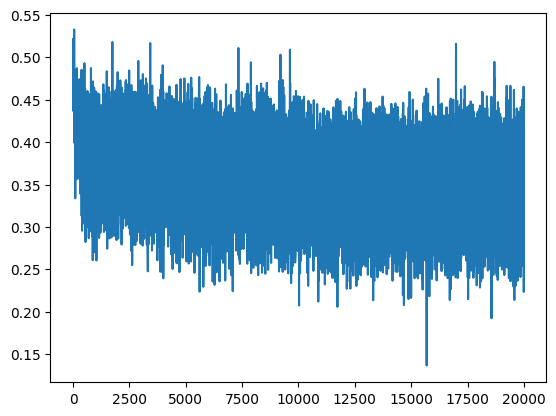

In [69]:
plt.plot(lossi)

In [70]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = torch.tanh(embcat @ W1 + b1)
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True)
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  logits = hpreact @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.6962220668792725
val 2.7074835300445557


In [71]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
    context = context[1:]+[ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mrragmmyazlizelmndhnnalllenmrngendrleg.
lzelldnelinglll.
jellenginghnlearlellzimllkarin.
shdbvrghhirinlarnavellll.
lugbrucfoubmanddl.
dyldll.
mhs.
llanavellllanhll.
dalynnsullubmalvennell.
ryvisvevohnnnohdillhnnohoeh.
gprilldamnnaxh.
hmrerlling.
jin.
lvondwrlla.
lltarlll.
mndglell.
blinglexvallinla.
mellrkendrllynxabna.
dam.
chenngkandmarudnail.
